# Sequence-to-sequence model to unconcatenate text
-----------

## Dependencies

These are all the modules we'll be using later. Make sure you can import them before proceeding further.

In [74]:
from __future__ import print_function
import tensorflow as tf
import tensorflow
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import string
sys.path.append('../dataset_tools')
import dataset_tools
from six.moves import range

## Download and load text8 dataset

For more info on text8 dataset, please visit [this site](http://mattmahoney.net/dc/).

In [15]:
dataset_file = dataset_tools.maybe_download()
text = dataset_tools.read_dict_file(dataset_file)
words = text.split(" ")
print("Data size %d" % len(text))
print("Word count %d" % len(words))

Found and verified /Users/pedro/vanhack/i2x-challenge/dataset_tools/text8.zip
Data size 100000000
Word count 17005208


## Extract input and labels for the dataset

The dataset is composed of a series of words from wikipedia articles dump. The text is already in lower case, there is no punctuation and no numbers. Basically, there are only characters from a to z and whitespaces.

For this challenge, we have to create a dataset with input and labels like:
- X: iwanttogotoberlin
- Y: i want to go to berlin



In [25]:
MAX_WORDS_PER_SENTENCE = 10

def extract_input_and_labels(words):
    def create_xy(fixed_size_words):
        return (''.join(fixed_size_words), ' '.join(fixed_size_words))
    
    return [create_xy(words[i:i+MAX_WORDS_PER_SENTENCE]) 
            for i in range(0, len(words), MAX_WORDS_PER_SENTENCE)]

data = extract_input_and_labels(words)
print("Data size %d" % len(data))

Data size 1700521


In [26]:
print("Some examples:")
idxs = np.random.randint(0, high=len(data), size=10)
for i in idxs:
    print("X: %s" % data[i][0])
    print("Y: %s" % data[i][1])

Some examples:
X: sixalbumsothetitlereferstothethreeseven
Y: six album so the title refers to the three seven
X: wesleyanarminianismfourviewsoneternalsecuritygrandrapidszondervan
Y: wesleyan arminianism four views on eternal security grand rapids zondervan
X: collationofvaryingmanuscriptsandintheindependentmanuscripttraditions
Y: collation of varying manuscripts and in the independent manuscript traditions
X: grouptheeritreanpeoplesliberationfronteplftheleadership
Y: group the eritrean people s liberation front eplf the leadership
X: jrofphiladelphiapennsylvaniaknownbyhisscreenameerifllehhellfire
Y: jr of philadelphia pennsylvania known by his screename eriflleh hellfire
X: arefromeightzerozeroamonezerozero
Y: are from eight zero zero a m one zero zero
X: asashootingwarinantarcticabetweenrivaladvertiserszik
Y: as a shooting war in antarctica between rival advertisers zik
X: fromcrushingobligationandoverworkandfamilyexpectationsandthe
Y: from crushing obligation and overwork and family 

## Exploring the data

Let's see how the lengths of the encoded and decoded sentences are distributed.

In [73]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.DataFrame(data=[[len(d[0]), len(d[1])] for d in data], columns=["encoder_length", "decoder_length"])
df.describe()

,encoder_length,decoder_length
count,1700521.000,1700521.000
mean,48.806,57.806
std,9.004,9.004
min,10.000,19.000
25%,43.000,52.000
50%,48.000,57.000
75%,54.000,63.000
max,198.000,207.000


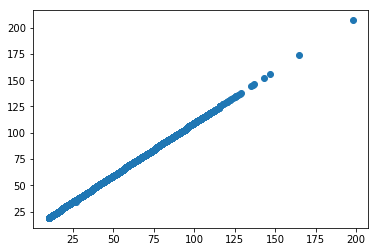

In [81]:
plt.scatter(df["encoder_length"].tolist(), df["decoder_length"].tolist())
plt.show()

As we can see from the graph above, there are some outliers in this dataset. Our model works with fixed input sizes, so if we accept sentences with such varying lengths, the model training the model.

Since we randomly generated the sentences, there

## Shuffling

To improve training, validation and test split.

In [27]:
np.random.shuffle(data)

## Train, Valid and Test split

We are doing 80, 10, 10 split

In [32]:
train_size = int(round(len(data) * .8))
test_size = int(round(len(data) * .1))
valid_size = len(data) - train_size - test_size

train = data[:train_size]
valid = data[train_size:(train_size + valid_size)]
test = data[(train_size + valid_size):]

print("train, valid, test sizes:", len(train), len(valid), len(test))

train, valid, test sizes: 1360417 170052 170052


## Utility functions
Utility functions to map characters to vocabulary IDs and back. We will be using control characters as following:

- `#` represents _padding_, i.e., null space inside a string.
- `^` represents _go_, i.e., the start of the translated string.
- `$` represents _eos_, i.e., the end of a translated string.
- ` ` represents _whitespace_.
- `?` represents unknown characters.

In [59]:
CONTROL_CHARS = [
    ('#', 0), # PAD
    ('^', 1), # GO
    ('$', 2), # EOS
    (' ', 3), # whitespace
    ('?', 4)  # UNK
]

control_size = len(CONTROL_CHARS)
vocabulary_size = len(string.ascii_lowercase) + control_size # [a-z] + CONTROL_CHARS
first_letter = ord(string.ascii_lowercase[0])

def control_char_by_char(char):
    for x in CONTROL_CHARS:
        if char == x[0]:
            return x
    
def control_char_by_value(value):
    for x in CONTROL_CHARS:
        if value == x[1]:
            return x

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + control_size
  elif char in [x[0] for x in CONTROL_CHARS]:
    return control_char_by_char(char)[1]
  else:
    return control_char_by_char('?')[1]
  
def id2char(dictid):
  if dictid >= control_size:
    return chr(dictid + first_letter - control_size)
  else:
    return control_char_by_value(dictid)[0]

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(5), id2char(30), id2char(0), id2char(1), id2char(2), id2char(3), id2char(4))

5 30 3 4
a z # ^ $   ?


## Bucketing

We need buckets, because the length of the input string and translate string differs.

Buckets define encoder and decoder sizes, so that we have multiple model, with different, but fixed, input and output sizes.

[Read more about buckets](https://www.tensorflow.org/tutorials/seq2seq#bucketing_and_padding)

To define how many buckets, and which sizes, we need to explore the dataset a bit.